In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
import ast
import mne 
import sys
import submitit
import gc
import matplotlib.pyplot as plt
import re 
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np


In [3]:
region = 'VISp'
path_table_info = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/extraction_module/data/eid_probe_info_{region}_{region}.csv'
table = pd.read_csv(path_table_info)
table['pid1'] = table['pid1'].apply(ast.literal_eval)
pids = []
eids = []
for i, row in enumerate(table.iterrows()):
    eid = row[1]['eid']
    pid1 = row[1]['pid1']
    for pid in pid1:
        if os.path.isfile(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'):
            pids.append(pid)
            eids.append(eid)
print(f'Number of pids with files: {len(pids)} for region {region}')

Number of pids with files: 46 for region VISp


In [4]:
eid = '032ffcdf-7692-40b3-b9ff-8def1fc18b2e'
pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'

from one.api import ONE

import brainbox.io.one as bbone
import brainbox.task.passive as passive
from brainbox.io.one import SpikeSortingLoader

import ibldsp.voltage as voltage
import spikeglx

one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

# new way of getting epoch data (for one epoch example)
getting stim onset sample directly 

In [4]:
ssl = SpikeSortingLoader(pid=pid, one=one)
# The channels information is contained in a dict table / dataframe
channels = ssl.load_channels()
stimOn_times = one.load_object(ssl.eid, 'trials', collection='alf')['stimOn_times']
sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
i = 541
t_event = stimOn_times[i]

sample_lf = int(ssl.samples2times(t_event, direction='reverse') / 12)
window_secs = [-0.5, 1]  
first, last = (int(window_secs[0] * sr_lf.fs + sample_lf), int(window_secs[1] * sr_lf.fs + sample_lf))
raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
destriped = voltage.destripe_lfp(raw_lf.astype(float), fs=sr_lf.fs)
decimated = mne.filter.resample(destriped.astype(float), up=2.0, down=10.0, window='boxcar', npad='auto', pad='reflect_limited', verbose=False)
print(t_event)

3369.1989889133356


# old way of getting epoch data 


In [6]:
import os
import re
import mne
import numpy as np
import pandas as pd

raw_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'
behavior_path = f'/mnt/data/AdaptiveControl/IBLrawdata/eid_data/{eid}/trials_{eid}.pkl'
behavior = pd.read_pickle(behavior_path)
raw = mne.io.read_raw_fif(raw_path, preload=True)
start_time = raw.first_samp / raw.info['sfreq']
time_diff = t_event - start_time
sample = int(time_diff * raw.info['sfreq'])
data = raw.get_data(start=sample - int(0.5 * raw.info['sfreq']), stop=sample+int(1 * raw.info['sfreq']), picks='all')




Opening raw data file /mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_raw.fif...
Isotrak not found
    Range : 102483 ... 1499482 =    204.966 ...  2998.964 secs
Ready.
Opening raw data file /mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_raw-1.fif...
Isotrak not found
    Range : 1499483 ... 2002370 =   2998.966 ...  4004.740 secs
Ready.
Reading 0 ... 1899887  =      0.000 ...  3799.774 secs...


# difference plot

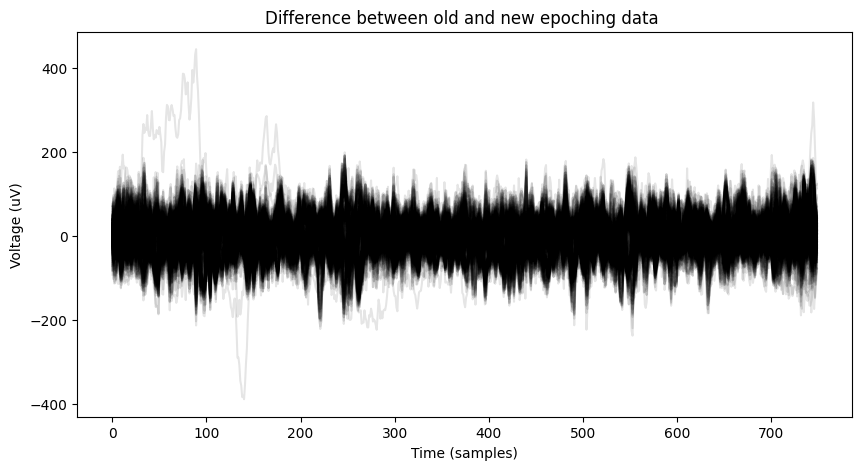

In [10]:
diff = (data - decimated) * 1e6  # convert to uV
# plot the difference
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(diff.T, 'k', alpha=0.1)
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Difference between old and new epoching data ')
plt.show()

In [9]:
def get_epoch_data(pid):
    from one.api import ONE
    one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    one = ONE(password='international')
    from brainbox.io.one import SpikeSortingLoader
    import ibldsp.voltage as voltage
    ssl = SpikeSortingLoader(pid=pid, one=one)
    path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_new_average.fif'
    stimOn_times = one.load_object(ssl.eid, 'trials', collection='alf')['stimOn_times']
    sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
    epoch_data = []
    for i in range(len(stimOn_times) - 1):
        t_event = stimOn_times[i]

        sample_lf = int(ssl.samples2times(t_event, direction='reverse') / 12)
        window_secs = [-0.5, 1]  
        first, last = (int(window_secs[0] * sr_lf.fs + sample_lf), int(window_secs[1] * sr_lf.fs + sample_lf))
        raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
        destriped = voltage.destripe_lfp(raw_lf.astype(float), fs=sr_lf.fs)
        decimated = mne.filter.resample(destriped.astype(float), up=2.0, down=10.0, window='boxcar', npad='auto', pad='reflect_limited', verbose=False)
        epoch_data.append(decimated)
    epoch_data = np.array(epoch_data)
    average = np.mean(epoch_data, axis=0, keepdims=False)
    np.save(path, average)
    return 

In [10]:
import submitit

joblist = []

executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=24, timeout_min=300, slurm_partition="CPU", cpus_per_task=1)

# Submit jobs
for pid in pids:
    job = executor.submit(get_epoch_data, pid)
    
print('All jobs submitted')

All jobs submitted


In [10]:
def epoch_stimOnset(raw, behavior, region = 'VISp', tmin=-0.5, tmax=1, baseline= None):
    raw.info['bads'] = []
    bad_channels = []
    Visual_channels_clean = [ch for ch in raw.ch_names if isinstance(ch, str) and re.match(rf'^{region}[12456]', ch) and ch not in bad_channels]
    # get indices of channels 
    indices = [raw.ch_names.index(ch) for ch in Visual_channels_clean]
    raw = raw.pick_channels(Visual_channels_clean)
    events, event_id = mne.events_from_annotations(raw)
    behavior_stimOnset = behavior.dropna(subset=['stimOn_times']) 
    stimOn_times_events = events[events[:, 2] == event_id['stimOn_times']]
    epochs = mne.Epochs(raw, stimOn_times_events, event_id['stimOn_times'], tmin, tmax, baseline= baseline, preload=True, metadata=behavior_stimOnset, reject=None)
    return epochs, Visual_channels_clean, indices

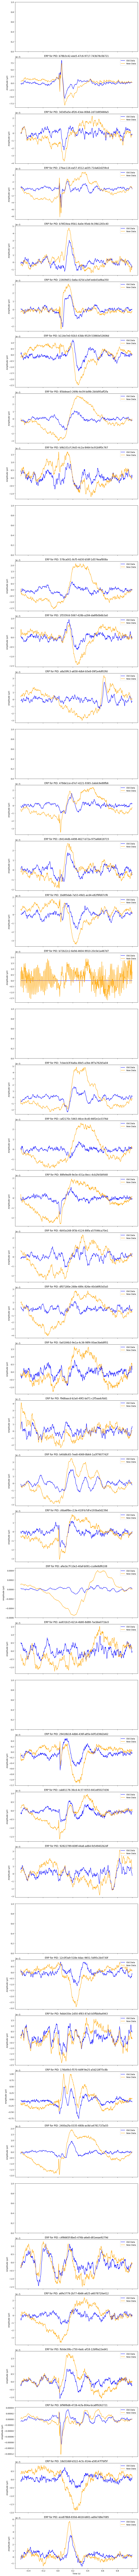

In [11]:
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/TFR/functions'))
from new_annotation import new_annotation
mne.set_log_level('ERROR')
# Set up the figure with subplots
fig, axes = plt.subplots(len(pids), 1, figsize=(10, len(pids)*4), sharex=True)

# Ensure axes is an array, even if only one subplot
if len(pids) == 1:
    axes = [axes]

for i, (eid, pid) in enumerate(zip(eids, pids)):
    # Load the new data
    path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_new_average.fif.npy'
    if not os.path.isfile(path):
        continue
    epoch_data_new = np.load(path)

    # Load the old data
    path_old = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'
    if not os.path.isfile(path_old):
        continue
    data_old = mne.io.read_raw_fif(path_old, preload=True)
    behavior_path = f'/mnt/data/AdaptiveControl/IBLrawdata/eid_data/{eid}/trials_{eid}.pkl'
    if not os.path.isfile(behavior_path):
        continue
    behavior = pd.read_pickle(behavior_path)
    
    # Annotate the old data
    data_old = new_annotation(data_old, behavior)
    
    # Extract epochs and indices for aligning old and new data
    epochs, ch_names, indices = epoch_stimOnset(data_old, behavior)
    epoch_data_old = epochs.get_data()
    
    # Average old data across epochs
    epoch_data_old = np.mean(epoch_data_old, axis=0, keepdims=False)
    
    # Align new data with old data using the extracted indices
    epoch_data_new = epoch_data_new[indices, :]
    
    # Get time points for plotting
    time = epochs.times
    times = time[:epoch_data_new.shape[1]]
    
    # Ensure old data matches new data length
    epoch_data_old = epoch_data_old[:, :epoch_data_new.shape[1]]
    
    # Plot old and new data in the same subplot
    ax = axes[i]
    ax.plot(times, epoch_data_old.mean(axis=0), label='Old Data', color='blue', lw=1.5)
    ax.plot(times, epoch_data_new.mean(axis=0), label='New Data', color='orange', lw=1.5)
    
    # Set title for each subplot
    ax.set_title(f'ERP for PID: {pid}')
    
    # Add labels and legends
    ax.set_ylabel('Amplitude (µV)')
    ax.legend(loc='upper right')

# Set common x-axis label
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()
